# Long Lived Particle Search @ CMS
## Cursory Analysis Notebook

Author - Paul Simmerling

Contact - psimmerl@caltech.edu

---

### Plots Wanted:

Two DataFrames (ALL PLOTS COMPARE THESE TWO):
* Inclusive (raw data)
  * ROOT.kBlue
* with MET cut (MET > 200 GeV, old analysis)
  * ROOT.kRed

* Reproduce cut-flow and efficiencies of the standard MET>200 analysis
* Remove MET>200 cut, then check which kinematic effects are changed:
  * Impact on LLP pT, and LLP energy (gen-level)
  * Change in Cluster efficiency
  * Change in ClusterSize shape
  * Change in deltaPhi (MET , cluster) distribution
  * What’s the MET distribution after requiring at least one cluster with clusterSize > 200 (or whatever passes the trigger)
  * What’s the fraction of events with CSC-CSC, DT-CSC, a single CSC cluster only
  * Plot distribution of cluster ID cut variables ( NStation, MaxStation )



gHiggsE
gHiggsEta
gHiggsPhi
gHiggsPt


cscRechitCluster_match_gLLP_e


* Generated LLP Kinematics
* Generated Higgs Kinematics
  * P_{t}, 0 to 850
* Cluster Efficiency vs Z Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_z / gLLP_decay_vertex_z
* Cluster Efficiency vs r Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_r / gLLP_decay_vertex_r
* N_{hits} cscRechitClusterSize, 0 to 2000 or 3000
  * MET After At least one cluster with ClusterSize > 200
* R Decay Position vs Z Decay Position, (Z=[400, 1100], R=[100, 750])
  * Signal Efficiency
* DeltaPhi, 0 to 3.25
* ctau

* Cluster Time (Background rejection), -80 to 80ns
* N_{stations}, cscRechitClusterNStation10, 0 to 5
* Cluster Eta, 0.8 to 2
* Avg Station Number, 0 to 5
* Max Station Number, 0 to 5

* Fraction of events with:
  * CSC-CSC, DT-CSC, DT-DT, single DT, and single CSC

* Table version of NStations

---

### Data Driven Background Estimation

DeltaPhi vs N_{rechits}

See christina slide in the short presentation



#### Cuts implemented:
- [ ] METNoMu tiggers
- [X] MET ≥ 200 GeV
- [X] Require ≥ 1 jet with jetPt > 50 GeV and |η| < 2.4
- [X] Require 0 leptons
- [X] signal-like RecHit cluster ID (CBID)
- [ ] Cluster RecHits with η-ɸ, distance parameter ΔR = 0.2
- [X] Require > 50 RecHits per cluster
- [ ] Merge clusters if two clusters are within ΔR < 0.6
- [X] CSC clusters to be in-time (-5 ns < t < 12.5 ns)
- [X] early OOT validation region ( t < -12.5 ns)
- [X] cluster time spread < 20 ns

Reject punch-through jets:
- [X] Veto clusters matched to jets (ΔR < 0.4)

Reject muon bremstralung shower:
- [X] Veto clusters matched to muons (ΔR < 0.4)
- [X] Veto clusters with RecHits in ME-1/1 or ME-1/2
- [X] Veto clusters that are matched to RE1/2 hits
- [X] Veto clusters that are matched to MB1 segments or RB1 hits
- [X] Veto clusters with |η| > 2.0


In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import ROOT as rt
# import csv
# import re
# import sys
# import collections

# from collections import OrderedDict
# import uproot
# import pandas as pd

# import scipy
# import awkward
import numpy as np
# import time
# import numba
# from numba import jit
# from matplotlib import pyplot as plt

from src import CMS_lumi, tdrstyle
# from src.histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

tdr = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

rt.gStyle.SetOptFit(1011)
rt.gStyle.SetOptStat(0)

wH = 1
Z_MASS = 91.2
gc = []

data_year = 'full'
years = ['Run3_Fall22']
fpath = 'data/raw/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
tree_name = 'MuonSystem'

lat = rt.TLatex()
lat.SetTextSize(0.05)
lat.SetTextAlign(11)



Welcome to JupyROOT 6.26/02


In [2]:
class MyRDataFrame:
    def __init__(self, *args, **kwargs) -> None:
        self.model_dict = {}
        self.default_color = None
        self.default_label = ""
        self.rdf = None
        if args or kwargs:
            self.rdf = rt.RDataFrame(*args, **kwargs)

    def Filter(self, cut):
        new_rdf = self.rdf.Filter(cut)
        new_myrdf = MyRDataFrame()
        new_myrdf.model_dict = self.model_dict
        new_myrdf.rdf = new_rdf

        return new_myrdf

    def Define(self, value, operation):
        new_rdf = self.rdf.Define(value, operation)
        new_myrdf = MyRDataFrame()
        new_myrdf.model_dict = self.model_dict
        new_myrdf.default_color = self.default_color
        new_myrdf.default_label = self.default_label
        new_myrdf.rdf = new_rdf

        return new_myrdf

    def Redefine(self, value, operation):
        new_rdf = self.rdf.Redefine(value, operation)
        new_myrdf = MyRDataFrame()
        new_myrdf.model_dict = self.model_dict
        new_myrdf.default_color = self.default_color
        new_myrdf.default_label = self.default_label
        new_myrdf.rdf = new_rdf

        return new_myrdf

    def set_default_color(self, color: rt.TColor) -> None:
        self.default_color = color

    def set_default_label(self, label: str) -> None:
        self.default_label = label

    def add_info(self, vname: str, model: tuple) -> None:
        self.model_dict[vname] = model

    def _create_binning(
        self, vname: str, mname: str = None, nbins: int = 100, plow: float = 5, phigh: float = 95
    ) -> tuple:
        if mname is None:
            mname = vname

        data = np.asarray(self.rdf.AsNumpy([vname])[vname].flatten())  # .as_type(np.ndarray)
        if not isinstance(data[0], (np.int32, np.float32)):
            data = np.array([x for vec in data for x in vec])

        title = f"{mname};{mname};count"
        nbins = nbins
        blow = np.percentile(data, plow)
        bhigh = np.percentile(data, phigh)

        model = (mname, title, nbins, blow, bhigh)
        self.model_dict[mname] = model

        return model

    def Histo1D(self, vname, model: tuple = None) -> rt.TH1:
        if model is None or isinstance(model, str):
            if model is str:
                mname = model
            else:
                mname = vname

            if mname in self.model_dict:
                model = self.model_dict[mname]
            else:
                model = self._create_binning(vname, mname)

        if model[0] not in self.model_dict:
            self.model_dict[model[0]] = model

        hist = self.rdf.Histo1D(model, vname)

        if self.default_color is not None:
            hist.SetLineColor(self.default_color)

        return hist

    def Histo2D(self, vnamex: str, vnamey: str, model: tuple = None):
        if model is None:
            model = (vnamex, vnamey)
        if len(model) == 2:
            modelx, modely = model[0], model[1]
            if modelx in self.model_dict:
                modelx = self.model_dict[modelx]
            else:
                modelx = self._create_binning(vnamex, modelx)

            if modely in self.model_dict:
                modely = self.model_dict[modely]
            else:
                modely = self._create_binning(vnamey, modely)

            xtitle, ytitle = modelx[1].split(";"), modely[1].split(";")
            title = ytitle[0] + " vs " + xtitle[0] + ";" + xtitle[1] + ";" + ytitle[1] + ";" + ytitle[2]
            model = (modelx[0] + "_" + modely[0], title, *modelx[2:], *modely[2:])

        if model[0] not in self.model_dict:
            self.model_dict[model[0]] = model

        hist = self.rdf.Histo2D(model, vnamex, vnamey)

        if self.default_color is not None:
            hist.SetLineColor(self.default_color)

        return hist


def Draw1D(v: str, rdfs: list, model=None, normalized=False) -> list:
    if not isinstance(rdfs, (list, tuple)):
        rdfs = [rdfs]

    if model is None:
        if v in rdfs[0].model_dict:
            model = rdfs[0].model_dict[v]
        else:
            models = [rdf._create_binning(v) for rdf in rdfs]
            model = (*models[0][:3], min([m[3] for m in models]), max([m[4] for m in models]))

    hhs = [rdf.Histo1D(v, model) for rdf in rdfs]
    hhs_sorted = [(hh.GetMaximum() / (hh.Integral() if normalized else 1), hh) for hh in hhs]
    hhs_sorted.sort(key=lambda x: x[0], reverse=True)
    for ih, hh in hhs_sorted:
        if normalized:
            if hh.GetYaxis().GetTitle() == "count":
                hh.GetYaxis().SetTitle("normalized")
            hh.DrawNormalized("same")

        else:
            hh.Draw("same")

    lat.SetTextAlign(33)
    lat.SetTextSize(0.05)
    for ih, (hh, rdf) in enumerate(zip(hhs, rdfs)):
        lat.SetTextColor(hh.GetLineColor())
        lat.DrawLatexNDC(0.95, 0.90 - ih * 0.05, rdf.default_label)

    gc.extend(hhs)

    return hhs, model

In [3]:
nb = 100
vals = ["met"]
vals += ["cscRechitCluster" + v for v in ["Size", "NStation10", "Eta", "AvgStation10", "MaxStation"]]
bins = [(nb, 0, 800), (nb, 0, 3000), (4, 0.5, 4.5), (nb, -2, 2), (nb, -4.5, 4.5), (9, -4.5, 4.5)]

model_dict = {}
for v, b in zip(vals, bins):
    model_dict[v] = (v, f"{v};{v};count", *b)

In [4]:
rdf_raw = MyRDataFrame(tree_name, fpath)
rdf_raw.model_dict = model_dict

# ,delta_metPhi_cscRechitClusterPhi_fixed'
# rdf_raw = rdf_raw.Define('delta_metPhi_cscRechitClusterPhi', 'metPhi - cscRechitClusterPhi')
vvals = "delta_metPhi_cscRechitClusterPhi,delta_metPhi_cscRechitClusterPhi_fixed,abs_cscRechitCluster_match_gLLP_decay_z,abs_cscRechitCluster_match_gLLP_decay_r,abs_gLLP_decay_vertex_z,abs_gLLP_decay_vertex_r"
rdf_raw = rdf_raw.Define(
    "vvals",
    """
ROOT::VecOps::RVec<double> delta_metPhi_cscRechitClusterPhi = ( metPhi - cscRechitClusterPhi );
ROOT::VecOps::RVec<double> delta_metPhi_cscRechitClusterPhi_fixed = delta_metPhi_cscRechitClusterPhi;
ROOT::VecOps::RVec<double> abs_cscRechitCluster_match_gLLP_decay_z = cscRechitCluster_match_gLLP_decay_z;
ROOT::VecOps::RVec<double> abs_cscRechitCluster_match_gLLP_decay_r = cscRechitCluster_match_gLLP_decay_r;
ROOT::VecOps::RVec<double> abs_gLLP_decay_vertex_z = gLLP_decay_vertex_z;
ROOT::VecOps::RVec<double> abs_gLLP_decay_vertex_r = gLLP_decay_vertex_r;

ROOT::VecOps::RVec<double> pass_delta_r_cut = 999*cscRechitClusterEta;// Not quite
ROOT::VecOps::RVec<double> pass_cluster_nrechits_cut = cscRechitClusterEta;
//ROOT::VecOps::RVec<double> merge_cluster_with = -1;
ROOT::VecOps::RVec<double> pass_cluster_jet_delta_r_cut = 999*cscRechitClusterEta;
ROOT::VecOps::RVec<double> pass_cluster_muon_delta_r_cut = 999*cscRechitClusterEta;
ROOT::VecOps::RVec<double> pass_cluster_rechits_ME11_ME12_cut = cscRechitClusterNRechitChamberMinus11;
ROOT::VecOps::RVec<double> pass_cluster_rechits_RE12_cut = cscRechitCluster_match_RE12_0p4;
ROOT::VecOps::RVec<double> pass_cluster_rechits_MB1_RB1_cut = cscRechitCluster_match_MB1Seg_0p4;
ROOT::VecOps::RVec<double> pass_cluster_eta_cut = cscRechitClusterEta;
ROOT::VecOps::RVec<double> pass_cluster_time_cut = cscRechitClusterTime;
ROOT::VecOps::RVec<double> pass_cluster_time_spread_cut = cscRechitClusterTimeSpread;
ROOT::VecOps::RVec<double> pass_cluster_OOT_cut = cscRechitClusterTime;
ROOT::VecOps::RVec<double> pass_cluster_CBID_cut = cscRechitClusterEta;// Cut-based ID


for (int i = 0; i < nCscRechitClusters; i++) {
  if ( delta_metPhi_cscRechitClusterPhi_fixed[i] > TMath::Pi() ) 
    delta_metPhi_cscRechitClusterPhi_fixed[i] -= 2 * TMath::Pi();
  else if ( delta_metPhi_cscRechitClusterPhi_fixed[i] < -TMath::Pi() ) 
    delta_metPhi_cscRechitClusterPhi_fixed[i] += 2 * TMath::Pi();

  abs_cscRechitCluster_match_gLLP_decay_z[i] = abs(abs_cscRechitCluster_match_gLLP_decay_z[i]);
  abs_cscRechitCluster_match_gLLP_decay_r[i] = abs(abs_cscRechitCluster_match_gLLP_decay_r[i]);
  abs_gLLP_decay_vertex_z[i] = abs(abs_gLLP_decay_vertex_z[i]);
  abs_gLLP_decay_vertex_r[i] = abs(abs_gLLP_decay_vertex_r[i]);

  pass_cluster_nrechits_cut[i] = (cscRechitClusterSize[i] > 50);

  // Not quite
  for (int j = i+1; j < nCscRechitClusters; j++) {
    pass_delta_r_cut[i] = TMath::Min( 
      pass_delta_r_cut[i], 
      TMath::Sqrt( (cscRechitClusterEta[i] - cscRechitClusterEta[j])*(cscRechitClusterEta[i] - cscRechitClusterEta[j])
                 + (cscRechitClusterPhi[i] - cscRechitClusterPhi[j])*(cscRechitClusterPhi[i] - cscRechitClusterPhi[j]) ) 
    );
  }
  pass_delta_r_cut[i] = ( pass_delta_r_cut[i] > 0.6 );

  for (int j = 0; j < nJets; j++) {
    pass_cluster_jet_delta_r_cut[i] = TMath::Min( 
      pass_cluster_jet_delta_r_cut[i], 
      TMath::Sqrt( (jetEta[i] - cscRechitClusterEta[j])*(jetEta[i] - cscRechitClusterEta[j])
                 + (jetPhi[i] - cscRechitClusterPhi[j])*(jetPhi[i] - cscRechitClusterPhi[j]) ) 
    );
  }
  pass_cluster_jet_delta_r_cut[i] = ( pass_cluster_jet_delta_r_cut[i] > 0.4 );
  

  for (int j = 0; j < nLeptons; j++) {
    if ( abs(lepPdgId[j]) == 13 ) {
      pass_cluster_muon_delta_r_cut[i] = TMath::Min( 
        pass_cluster_muon_delta_r_cut[i], 
        TMath::Sqrt( (lepEta[i] - cscRechitClusterEta[j])*(lepEta[i] - cscRechitClusterEta[j])
                   + (lepPhi[i] - cscRechitClusterPhi[j])*(lepPhi[i] - cscRechitClusterPhi[j]) ) 
      );
    }
  }
  pass_cluster_muon_delta_r_cut[i] = ( pass_cluster_muon_delta_r_cut[i] > 0.4 );

  pass_cluster_rechits_ME11_ME12_cut[i] = (
    (cscRechitClusterNRechitChamberMinus11[i] == 0) && 
    (cscRechitClusterNRechitChamberMinus12[i] == 0) && 
    (cscRechitClusterNRechitChamberPlus11[i] == 0) && 
    (cscRechitClusterNRechitChamberPlus12[i] == 0) );
  pass_cluster_rechits_RE12_cut[i] = ( cscRechitCluster_match_RE12_0p4[i] == 0 );
  pass_cluster_rechits_MB1_RB1_cut[i] = ( 
    ( cscRechitCluster_match_MB1Seg_0p4[i] == 0 ) && 
    ( cscRechitCluster_match_RB1_0p4[i] == 0 ) );
  pass_cluster_eta_cut[i] = ( abs(cscRechitClusterEta[i]) < 2.0 );
  pass_cluster_time_cut[i] = ( (-5.0 < cscRechitClusterTime[i]) && (cscRechitClusterTime[i] < 12.5) );
  pass_cluster_time_spread_cut[i] = ( cscRechitClusterTimeSpread[i] < 20 );
  pass_cluster_OOT_cut[i] = ( cscRechitClusterTime[i] < -12.5 );


  // Cut Based ID
  double eta = cscRechitClusterEta[i], avg_station = TMath::Floor( cscRechitClusterAvgStation10[i] );
  if ( cscRechitClusterNStation10[i] > 1 ) {
    pass_cluster_CBID_cut[i] = ( abs( eta ) < 1.9 );
  }
  else {
    if ( avg_station == 4 ) {
      pass_cluster_CBID_cut[i] = ( abs( eta ) < 1.8 );
    } else if ( avg_station == 3 ) {
      pass_cluster_CBID_cut[i] = ( abs( eta ) < 1.6 );
    } else if ( avg_station == 2 ) {
      pass_cluster_CBID_cut[i] = ( abs( eta ) < 1.6 );
    } else if ( avg_station == 1 ) {
      pass_cluster_CBID_cut[i] = ( abs( eta ) < 1.1 );
    }
  }
}
return vector<ROOT::VecOps::RVec<double>>{"""
    + vvals
    + "};",
)

dvals = "cscRechitClusterSizeAtLeastOneAbove200,cscRechitCluster_match_gLLP_AtLeastOne,test"
rdf_raw = rdf_raw.Define(
    "dvals",
    """
const double met_cut = 200, jetPt_cut = 50, jetEta_cut = 2.4, nLeptons_cut = 0;

double cscRechitClusterSizeAtLeastOneAbove200 = 0, cscRechitCluster_match_gLLP_AtLeastOne = 0;

double pass_met_cut = (met > 200);
double pass_jet_cut = 0;
double pass_lepton_cut = (nLeptons == 0);

for (int i = 0; i < nJets; i++) {
  pass_jet_cut += (jetPt[i] > 50)*(abs(jetEta[i]) < 2.4);
}

double test = 0;

for (int i = 0; i < nCscRechitClusters; i++) {
  if ( cscRechitClusterSize[i] > 200 )
    cscRechitClusterSizeAtLeastOneAbove200++;
  if (cscRechitCluster_match_gLLP[i] == true)
    cscRechitCluster_match_gLLP_AtLeastOne++;

  test += abs( cscRechitClusterMuonVetoEta[i] ) < 0.25;
}
return vector<double>{"""
    + dvals
    + "};",
)

for i, v in enumerate(vvals.split(",")):
    rdf_raw = rdf_raw.Define(v, f"vvals[{i}]")
for i, v in enumerate(dvals.split(",")):
    rdf_raw = rdf_raw.Define(v, f"dvals[{i}]")

#########

rdf_raw_matched = rdf_raw.Filter(
    "cscRechitCluster_match_gLLP_AtLeastOne && (nCscRechitClusters == cscRechitCluster_match_gLLP_AtLeastOne)"
)

# MET
rdf_met = rdf_raw.Filter("met > 200")
rdf_met_matched = rdf_met.Filter(
    "cscRechitCluster_match_gLLP_AtLeastOne && (nCscRechitClusters == cscRechitCluster_match_gLLP_AtLeastOne)"
)

# Rechit Size > 200
rdf_raw_csc = rdf_raw.Filter("cscRechitClusterSizeAtLeastOneAbove200 > 0")
rdf_met_csc = rdf_met.Filter("cscRechitClusterSizeAtLeastOneAbove200 > 0")

# 1 jet and lepton cuts

# CBID

# Cluster Cuts

# Jet cuts

# Muon cuts

# Time Cuts

#########

rdf_raw.default_color = rt.kBlue
rdf_met.default_color = rt.kRed
rdf_raw_csc.default_color = rt.kBlue - 6
rdf_met_csc.default_color = rt.kRed - 6
rdf_raw_matched.default_color = rt.kCyan
rdf_met_matched.default_color = rt.kMagenta

rdf_raw.default_label = "Inclusive"
rdf_met.default_label = "with MET cut"
rdf_raw_csc.default_label = "Inclusive, with CSC cut"
rdf_met_csc.default_label = "with MET cut, with CSC cut"
rdf_raw_matched.default_label = "Inclusive, matched"
rdf_met_matched.default_label = "with MET cut, matched"

#########

for rdf in (rdf_raw, rdf_met, rdf_raw_matched, rdf_met_matched):
    print(rdf.rdf.Count().GetValue())

2988000
31398
500076
4501


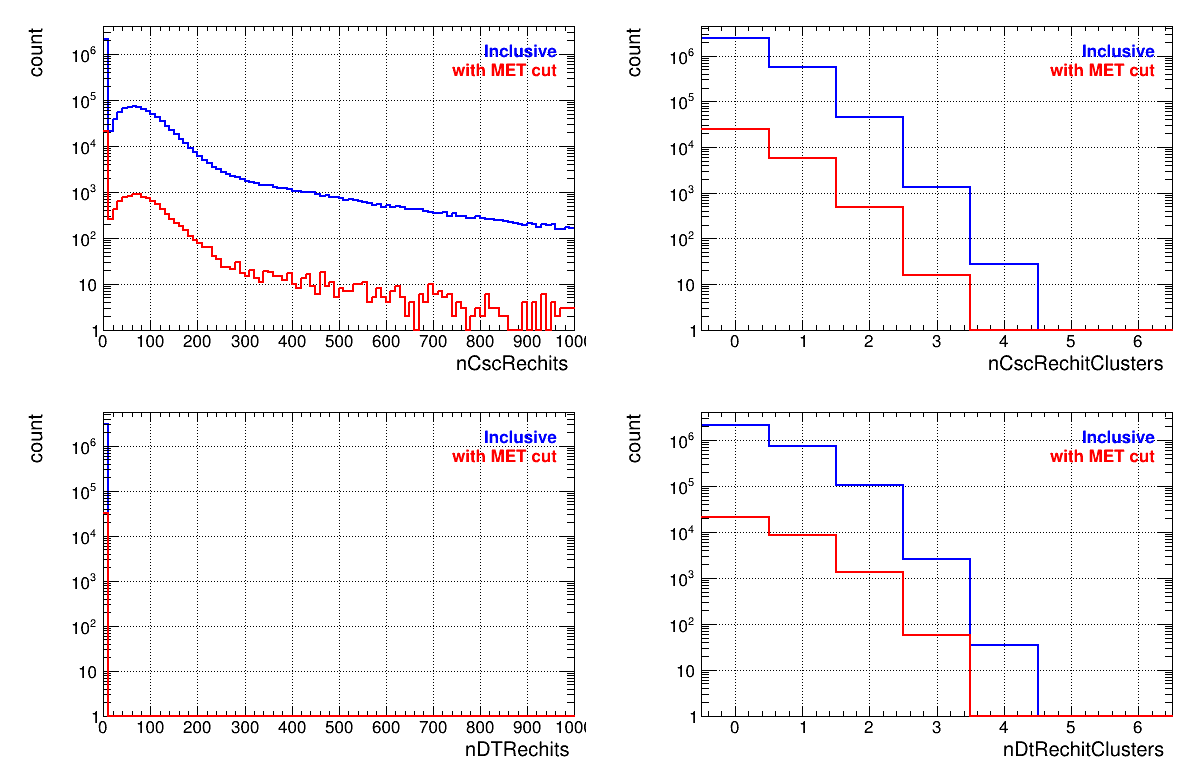

In [5]:
c = rt.TCanvas("c", "c", 2 * 600, 2 * 400)
c.Divide(2, 2)
c.Draw()

for i, (v, bins) in enumerate(
    zip(
        ["nCscRechits", "nCscRechitClusters", "nDTRechits", "nDtRechitClusters"],
        [(nb, 0, 1000), (7, -0.5, 6.5), (nb, 0, 1000), (7, -0.5, 6.5)],
    )
):
    c.cd(i + 1).SetLogy()
    model = (v, f"{v};{v};count", *bins)
    hhs, model = Draw1D(v, [rdf_raw, rdf_met], model=model, normalized=False)
    for hh in hhs:
        hh.SetMinimum(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


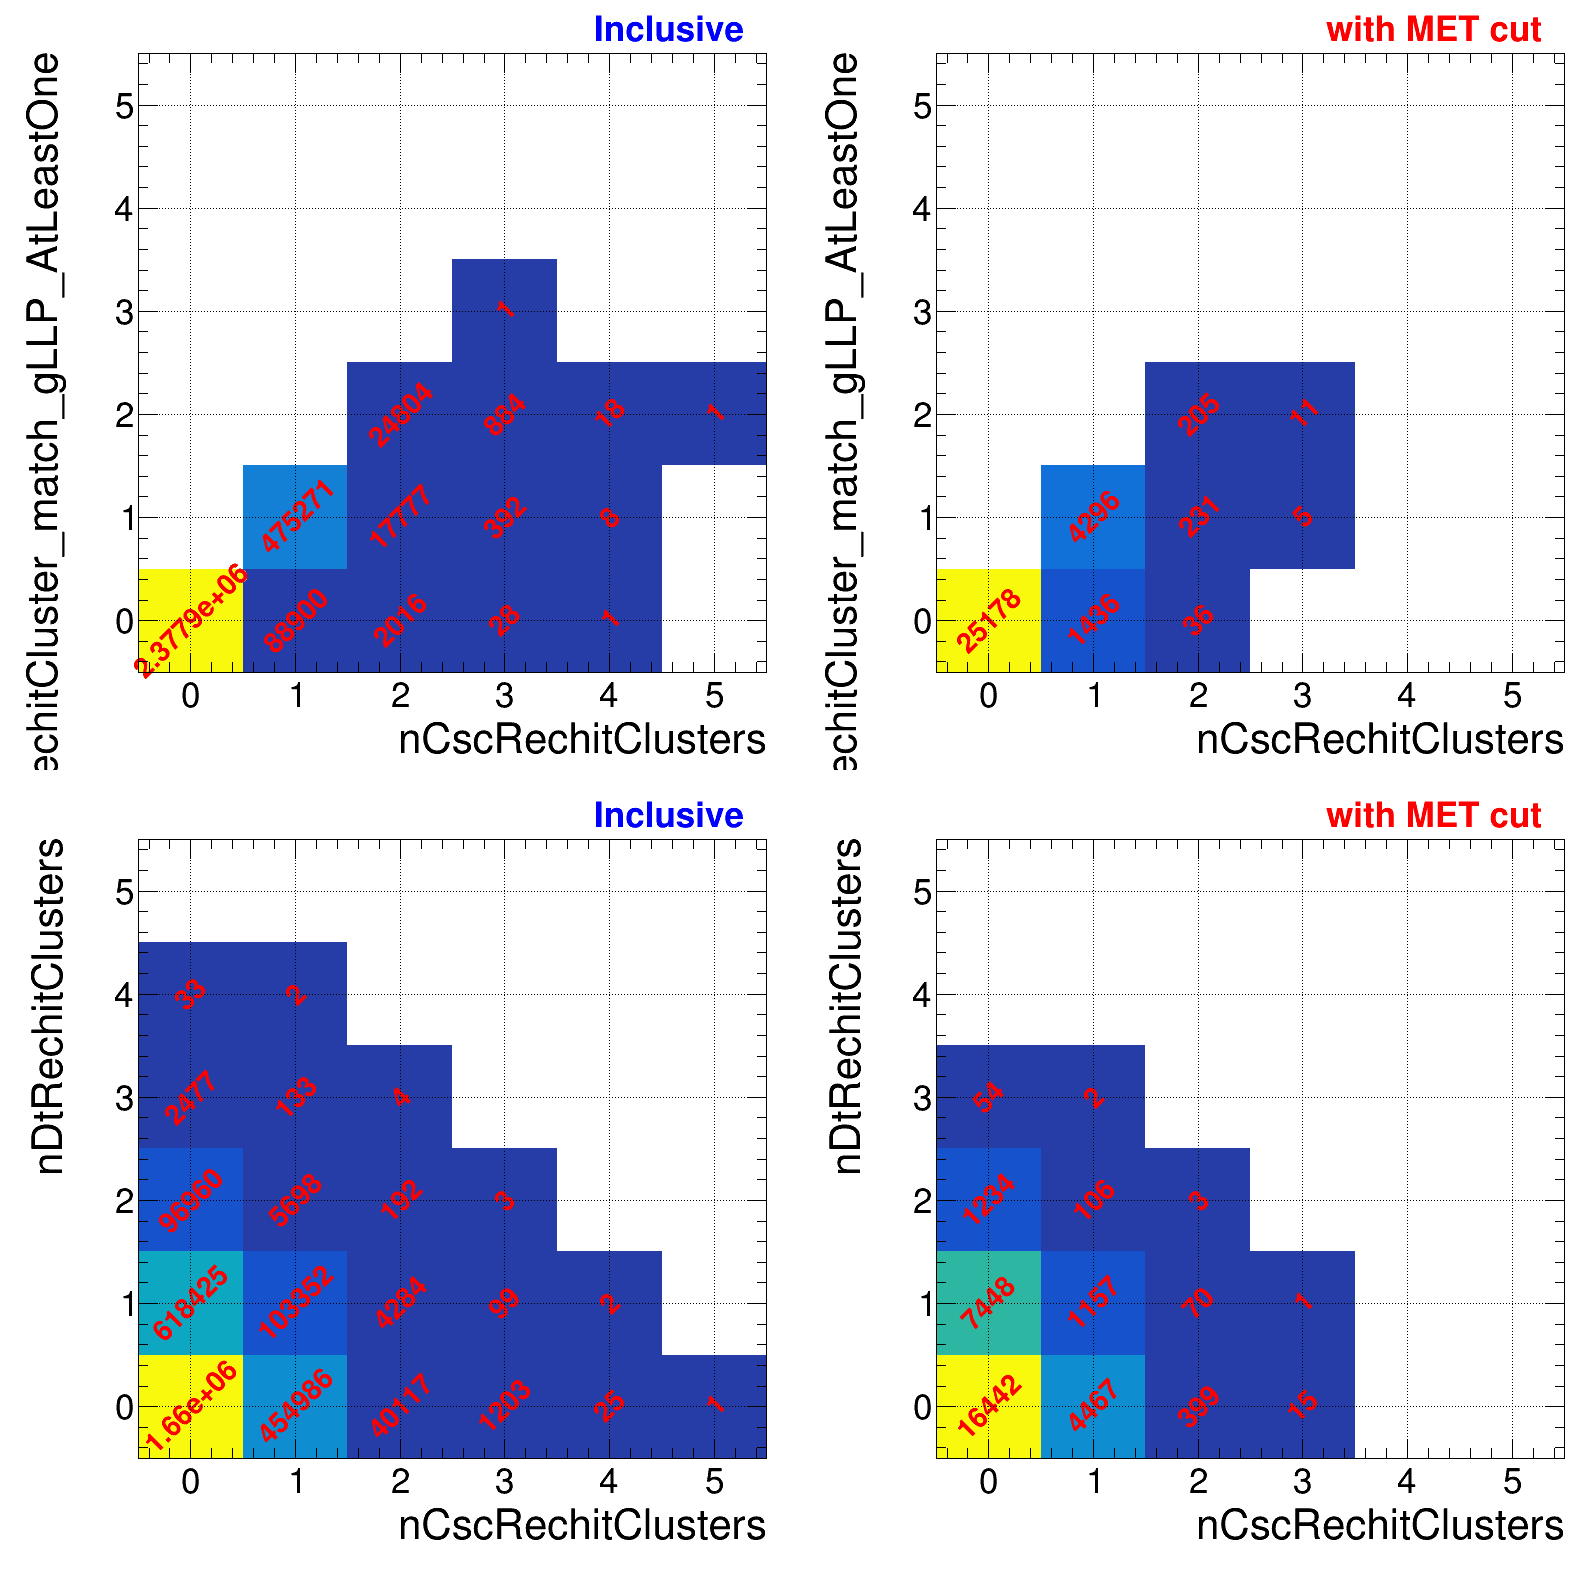

In [6]:
c = rt.TCanvas("c", "c", 2 * 800, 2 * 800)
c.Divide(2, 2)
c.Draw()


c.cd(1)
hraw = rdf_raw.Histo2D(
    "nCscRechitClusters",
    "cscRechitCluster_match_gLLP_AtLeastOne",
    ("", ";nCscRechitClusters;cscRechitCluster_match_gLLP_AtLeastOne;", 6, -0.5, 5.5, 6, -0.5, 5.5),
)
hraw.SetMarkerColor(rt.kRed)
hraw.SetMarkerSize(2)
hraw.Draw("coltext45")

lat.SetTextColor(hraw.GetLineColor())
lat.DrawLatexNDC(0.95, 1.00, rdf_raw.default_label)

c.cd(2)
hmet = rdf_met.Histo2D(
    "nCscRechitClusters",
    "cscRechitCluster_match_gLLP_AtLeastOne",
    ("", ";nCscRechitClusters;cscRechitCluster_match_gLLP_AtLeastOne;", 6, -0.5, 5.5, 6, -0.5, 5.5),
)
hmet.SetMarkerColor(rt.kRed)
hmet.SetMarkerSize(2)
hmet.Draw("coltext45")

lat.SetTextColor(hmet.GetLineColor())
lat.DrawLatexNDC(0.95, 1.00, rdf_met.default_label)

c.cd(3)
hraw2 = rdf_raw.Histo2D(
    "nCscRechitClusters",
    "nDtRechitClusters",
    ("", ";nCscRechitClusters;nDtRechitClusters;", 6, -0.5, 5.5, 6, -0.5, 5.5),
)
hraw2.SetMarkerColor(rt.kRed)
hraw2.SetMarkerSize(2)
hraw2.Draw("coltext45")

lat.SetTextColor(hraw2.GetLineColor())
lat.DrawLatexNDC(0.95, 1.00, rdf_raw.default_label)

c.cd(4)
hmet2 = rdf_met.Histo2D(
    "nCscRechitClusters",
    "nDtRechitClusters",
    ("", ";nCscRechitClusters;nDtRechitClusters;", 6, -0.5, 5.5, 6, -0.5, 5.5),
)
hmet2.SetMarkerColor(rt.kRed)
hmet2.SetMarkerSize(2)
hmet2.Draw("coltext45")

lat.SetTextColor(hmet.GetLineColor())
lat.DrawLatexNDC(0.95, 1.00, rdf_met.default_label)

# c.cd(3).SetLogy()
# v = 'cscRechitClusterTimeSpread'
# hhs, model = Draw1D(v, [rdf_raw,rdf_met], model=(v,f'{v};{v};count',20,-10,50),normalized=False)

\begin{tabular}{|| c || c  c | c c | c ||} 
  \hline
  Station & Inclusive, Count & Fraction & w/ MET cut, Count & Fraction & (w/ MET cut)/Inclusive \\ [0.5ex]
  \hline\hline
  1 & 301286 & 0.458 & 2888 & 0.430 & 0.010 \\
  2 & 240985 & 0.367 & 2441 & 0.363 & 0.010 \\
  3 & 88134 & 0.134 & 1054 & 0.157 & 0.012 \\
  4 & 26988 & 0.041 & 341 & 0.051 & 0.013 \\
[1ex]  \hline
  \end{tabular}
\begin{tabular}{|| c || c  c | c c | c ||} 
  \hline
  Station & Inclusive, Count & Fraction & w/ MET cut, Count & Fraction & (w/ MET cut)/Inclusive \\ [0.5ex]
  \hline\hline
  1 & 62437 & 0.095 & 601 & 0.089 & 0.010 \\
  2 & 45299 & 0.069 & 392 & 0.058 & 0.009 \\
  3 & 75925 & 0.115 & 833 & 0.124 & 0.011 \\
  4 & 144189 & 0.219 & 1520 & 0.226 & 0.011 \\
  5 & 0 & 0.000 & 0 & 0.000 & -1.000 \\
  6 & 145730 & 0.222 & 1513 & 0.225 & 0.010 \\
  7 & 78439 & 0.119 & 809 & 0.120 & 0.010 \\
  8 & 44373 & 0.067 & 432 & 0.064 & 0.010 \\
  9 & 61001 & 0.093 & 624 & 0.093 & 0.010 \\
[1ex]  \hline
  \end{tabular}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


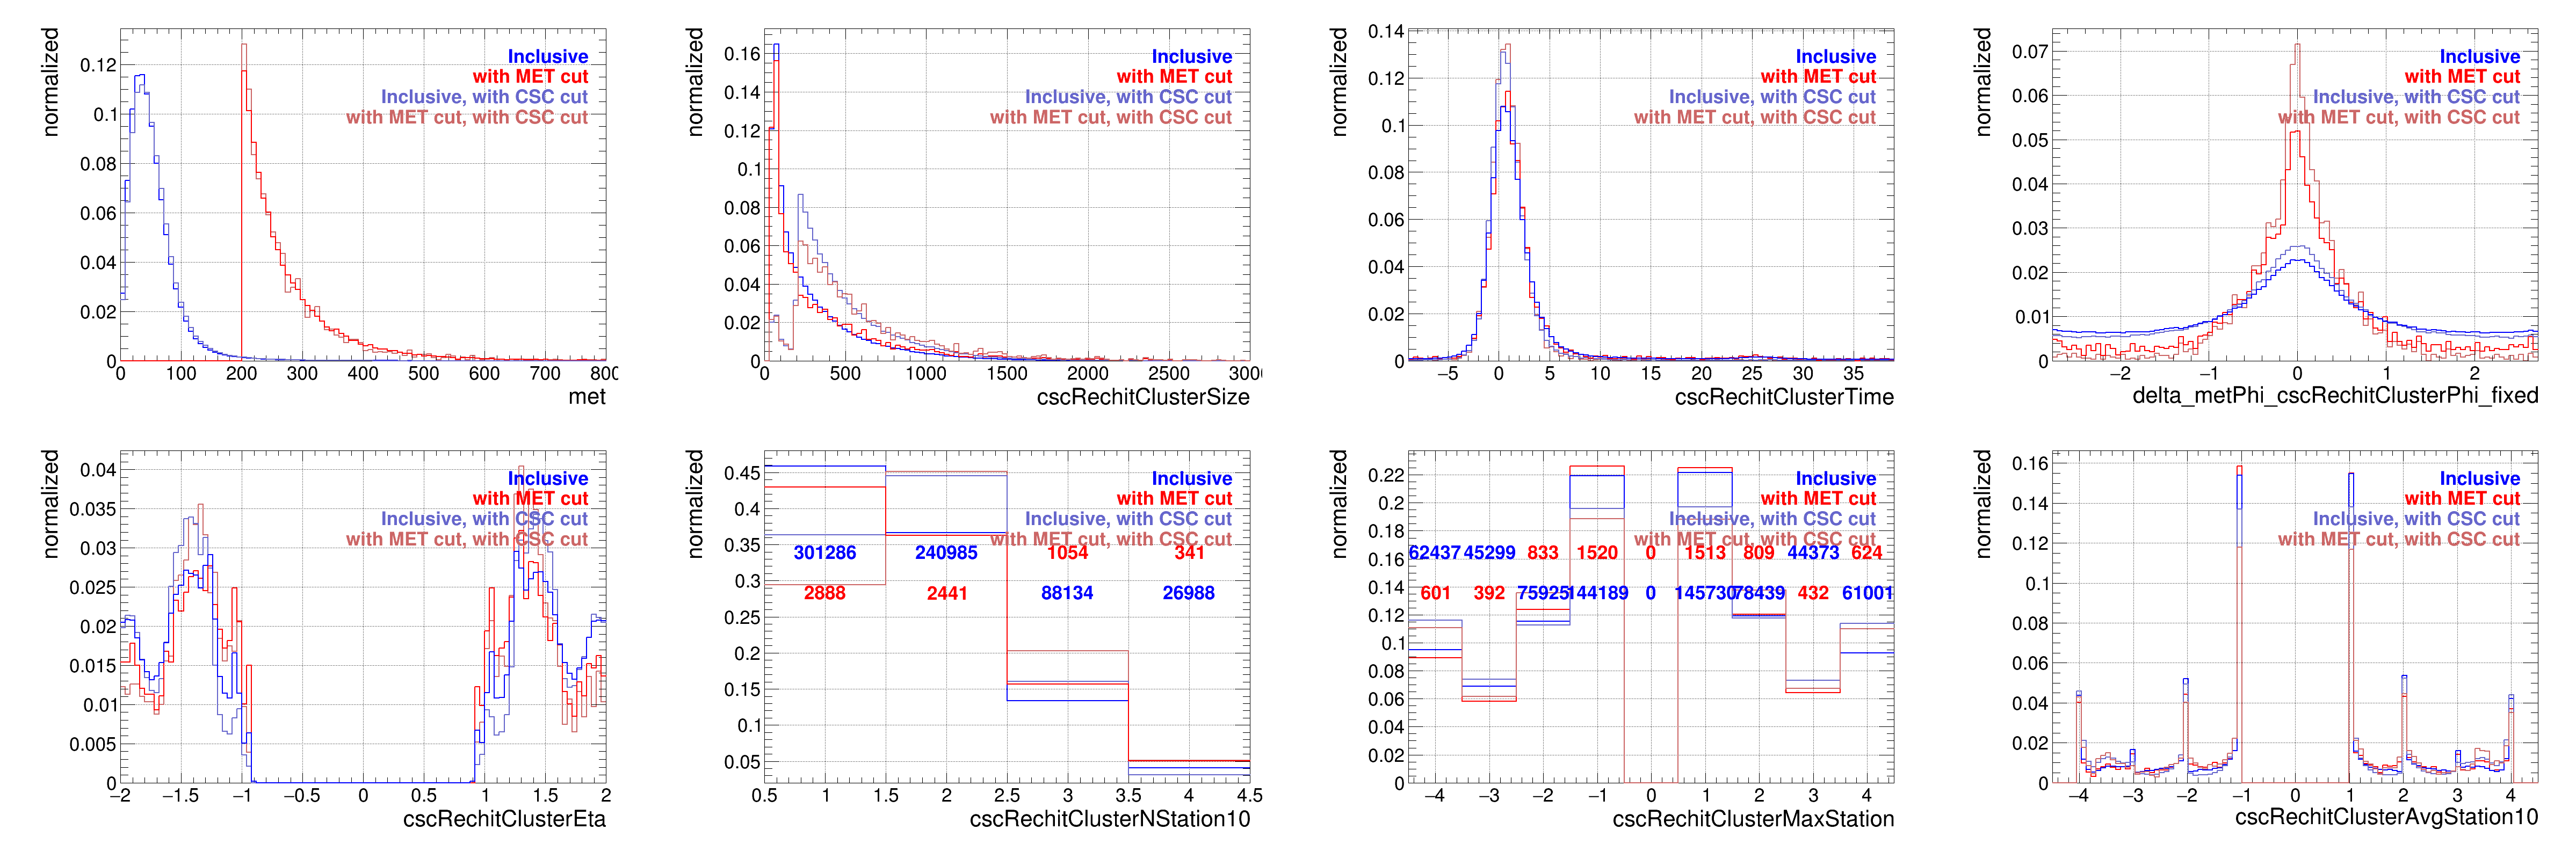

In [7]:
# Missing E_{t}, met
# Cluster Time (Background rejection), -80 to 80ns
# N_{hits} cscRechitClusterSize, 0 to 2000 or 3000
# MET After At least one cluster with ClusterSize > 200
# N_{stations}, cscRechitClusterNStation10, 0 to 5
# Cluster Eta, 0.8 to 2
# Avg Station Number, 0 to 5
# Max Station Number, 0 to 5

c = rt.TCanvas("c", "c", 4 * 1200, 2 * 800)
c.Divide(4, 2)
c.Draw()


for i, v in enumerate(
    [
        "met",
        "cscRechitClusterSize",
        "cscRechitClusterTime",
        "delta_metPhi_cscRechitClusterPhi_fixed",
        "cscRechitClusterEta",
        "cscRechitClusterNStation10",
        "cscRechitClusterMaxStation",
        "cscRechitClusterAvgStation10",
    ]
):
    c.cd(i + 1)  # .SetLogy()

    rdfs = [rdf_raw, rdf_met]  # , rdf_raw_matched]
    # if v in ('met', 'cscRechitClusterSize'):
    rdfs += [rdf_raw_csc, rdf_met_csc]
    hhs, model = Draw1D(v, rdfs, normalized=True)

    for hh in hhs:
        hh.SetMinimum(0)

    lat.SetTextAlign(22)
    if "NSta" in v or "MaxSta" in v:
        print(
            """\\begin{tabular}{|| c || c  c | c c | c ||} 
  \\hline
  Station & Inclusive, Count & Fraction & w/ MET cut, Count & Fraction & (w/ MET cut)/Inclusive \\\\ [0.5ex]
  \\hline\\hline"""
        )
        rint, mint = hhs[0].Integral(), hhs[1].Integral()
        for ib in range(1, model[2] + 1):
            bcr = hhs[0].GetBinContent(ib)
            bcm = hhs[1].GetBinContent(ib)
            lat.SetTextColor(hhs[0].GetLineColor())
            lat.DrawLatexNDC(
                (ib - 1 / 2) * (0.98 - 0.16) / model[2] + 0.16, 0.7 if bcr / rint > bcm / mint else 0.6, f"{bcr:.0f}"
            )
            lat.SetTextColor(rdf_met.default_color)
            lat.SetLineColor(hhs[1].GetLineColor())
            lat.DrawLatexNDC(
                (ib - 1 / 2) * (0.98 - 0.16) / model[2] + 0.16, 0.6 if bcr / rint > bcm / mint else 0.7, f"{bcm:.0f}"
            )

            mrdiv = bcm / bcr if bcr else -1
            print(f"  {ib} & {bcr:.0f} & {bcr/rint:.3f} & {bcm:.0f} & {bcm/mint:.3f} & {mrdiv:.3f} \\\\")

            # lat.SetTextColor(rt.kBlack)
            # bcd = bcm/bcr if bcr else 1
            # lat.DrawLatexNDC((ib-1/2)*(0.98-0.16)/model[2] + 0.16, 0.7, f'{bcd:.4f}')
        print(
            """[1ex]  \hline
  \end{tabular}"""
        )


# Table version of NStations

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


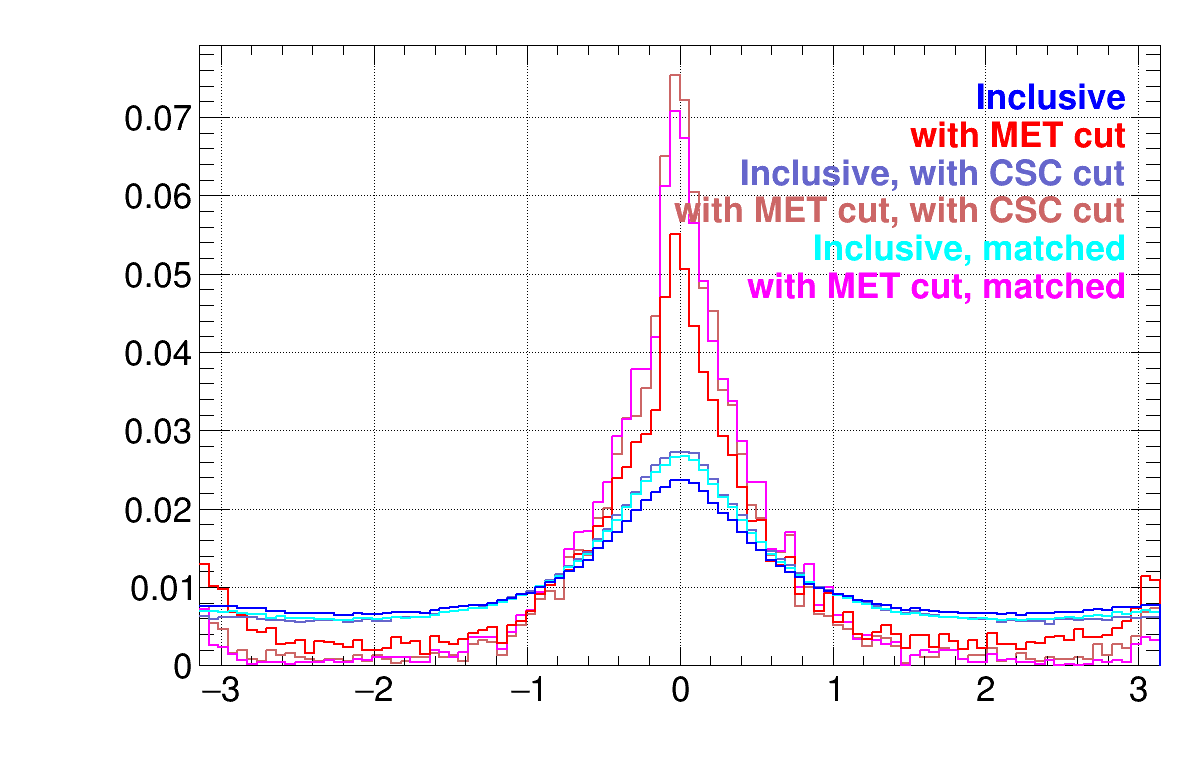

In [8]:
c = rt.TCanvas("c", "c", 1 * 1200, 1 * 800)
c.Divide(1, 1)
c.Draw()

c.cd(1)
v = "delta_metPhi_cscRechitClusterPhi_fixed"

hhs, model = Draw1D(
    v,
    [rdf_raw, rdf_met, rdf_raw_csc, rdf_met_csc, rdf_raw_matched, rdf_met_matched],
    model=("", "", 100, -3.1416, 3.1416),
    normalized=True,
)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


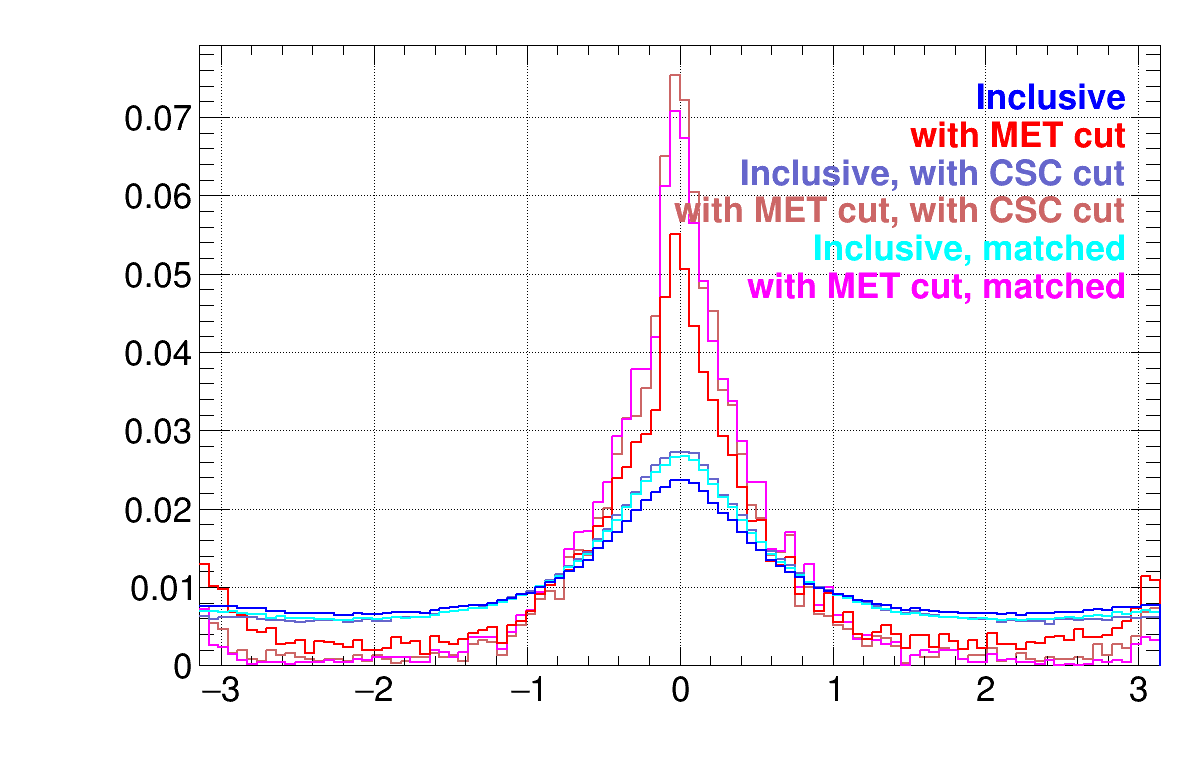

In [9]:
c = rt.TCanvas("c", "c", 1 * 1200, 1 * 800)
c.Divide(1, 1)
c.Draw()

c.cd(1)
v = "delta_metPhi_cscRechitClusterPhi_fixed"

hhs, model = Draw1D(
    v,
    [rdf_raw, rdf_met, rdf_raw_csc, rdf_met_csc, rdf_raw_matched, rdf_met_matched],
    model=("", "", 100, -3.1416, 3.1416),
    normalized=True,
)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


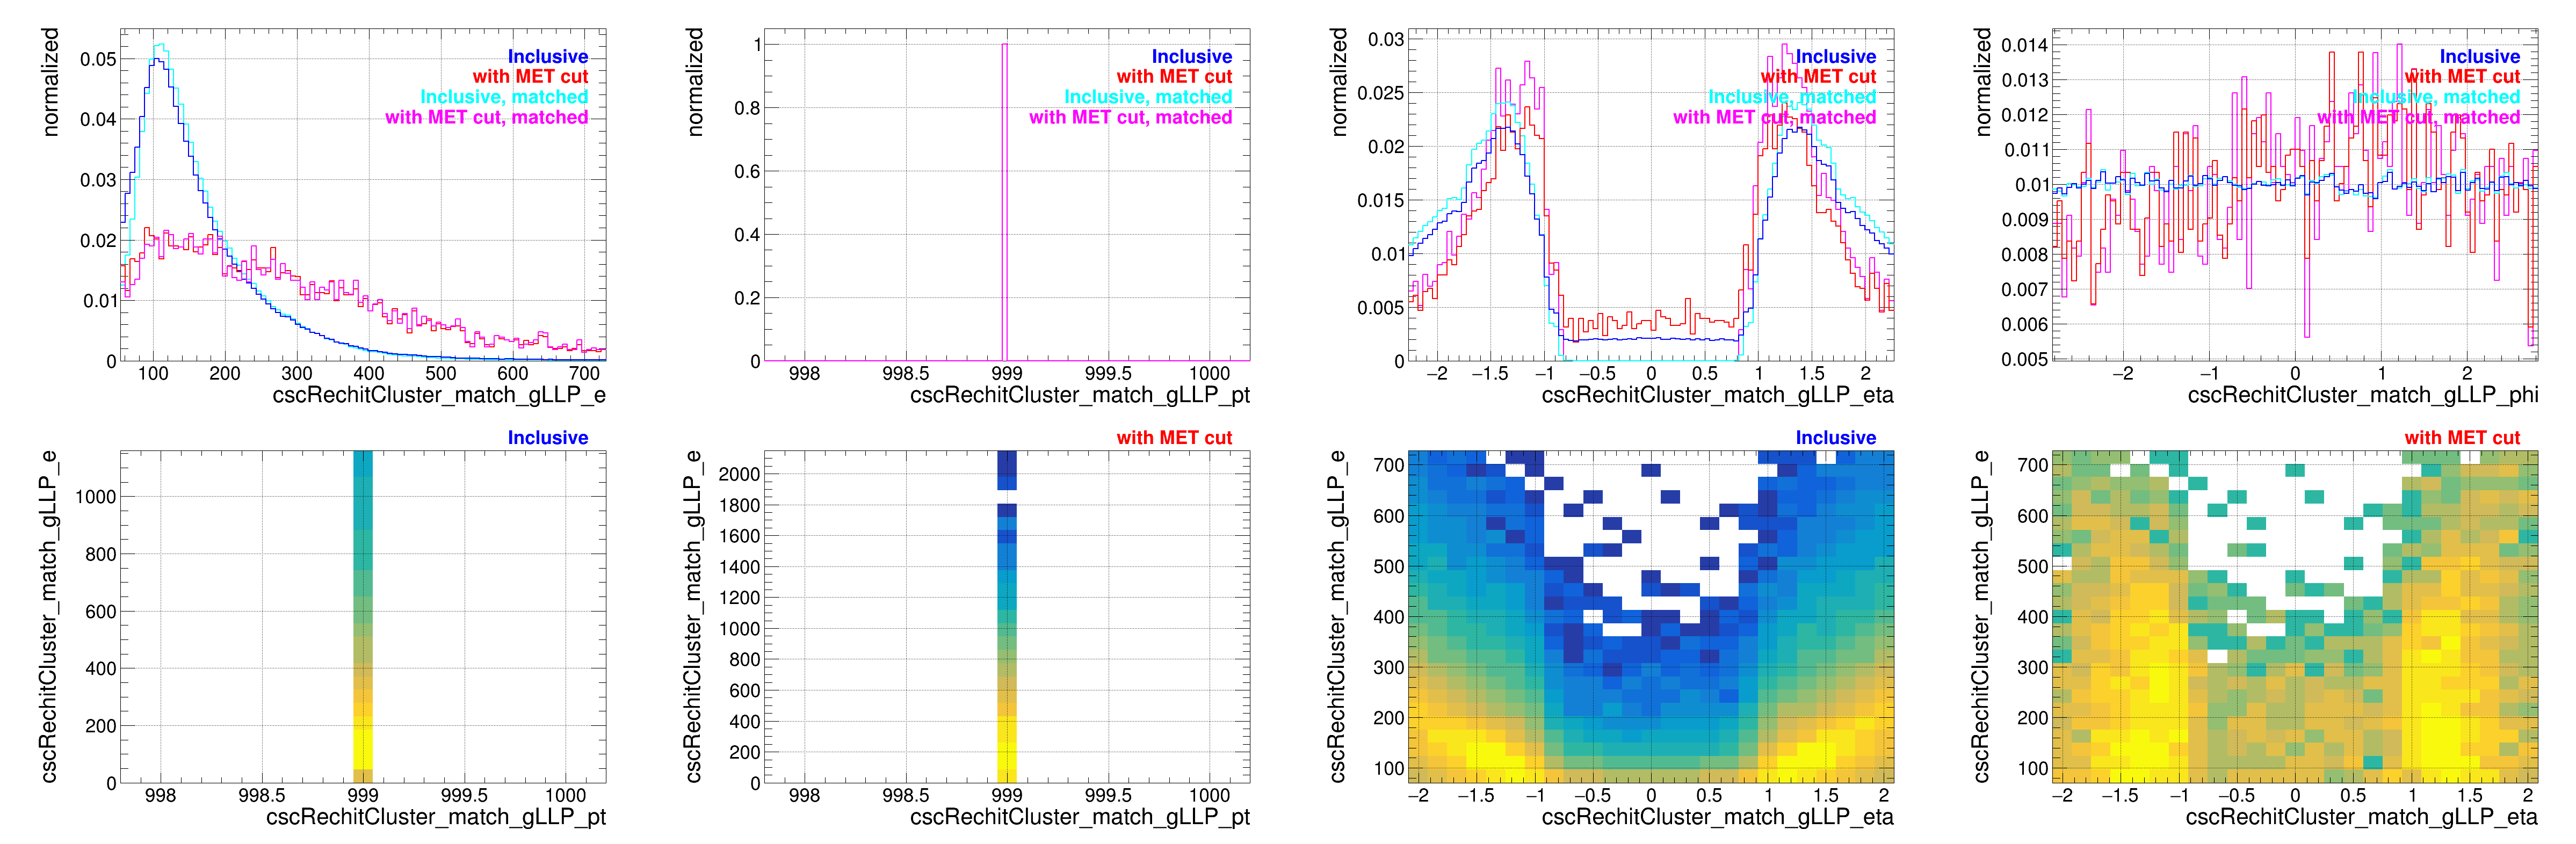

In [10]:
# Generated LLP Kinematics
# |P|, P_{t}, Eta, Phi,
c = rt.TCanvas("c", "c", 4 * 1200, 2 * 800)
c.Divide(4, 2)
c.Draw()

for i, vv in enumerate(["e", "pt", "eta", "phi"]):
    c.cd(i + 1)
    v = "cscRechitCluster_match_gLLP_" + vv

    rdfs = [rdf_raw, rdf_met, rdf_raw_matched, rdf_met_matched]
    hhs, model = Draw1D(v, rdfs, normalized=True)

# E vs Pt
# E vs Eta
for vvx in ["pt", "eta"]:
    vx, vy = "cscRechitCluster_match_gLLP_" + vvx, "cscRechitCluster_match_gLLP_e"
    for rdf in [rdf_raw, rdf_met]:
        i += 1
        c.cd(i + 1).SetLogz()
        hh = rdf.Histo2D(vx, vy)
        hh.Rebin2D(4, 4)
        hh.Draw("col")
        gc.append(hh)

        lat.SetTextColor(hh.GetLineColor())
        lat.DrawLatexNDC(0.95, 1.00, rdf.default_label)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


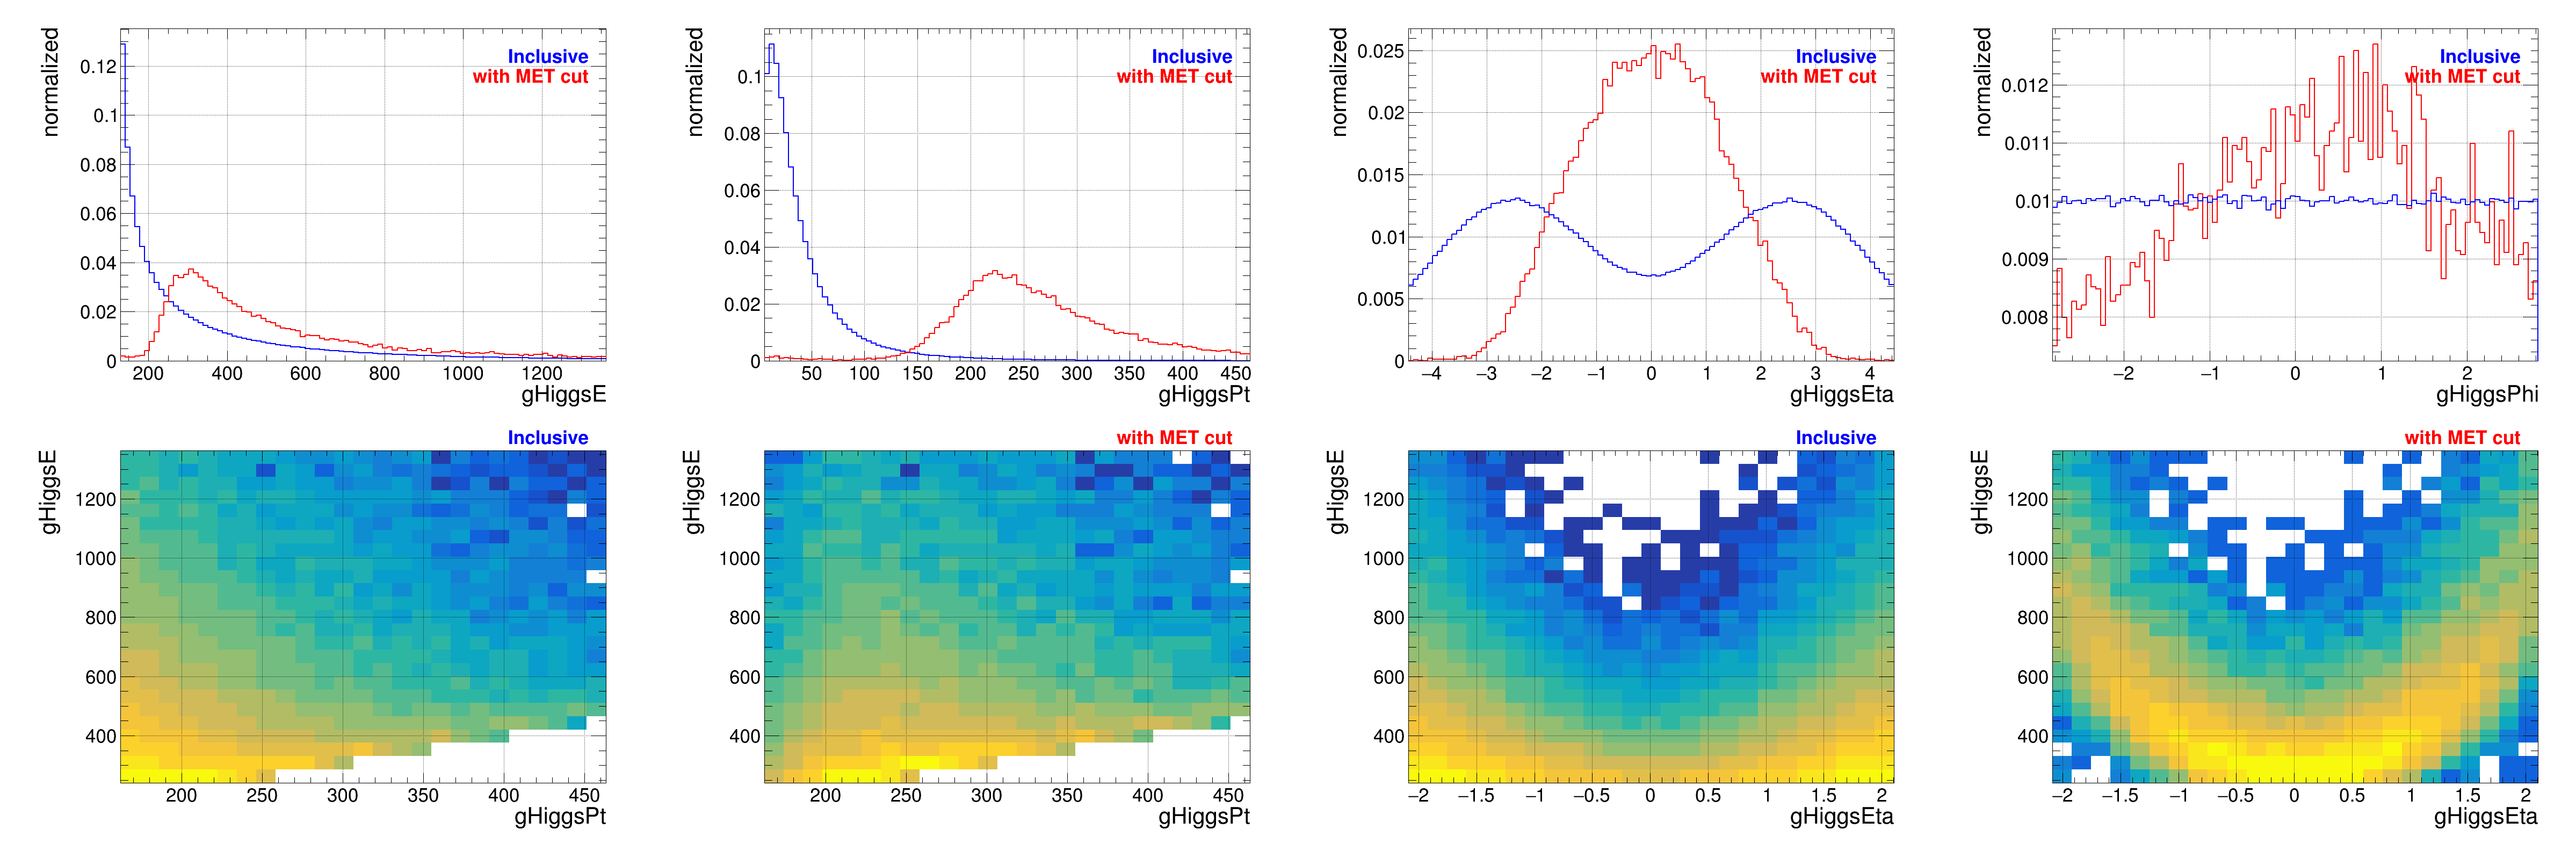

In [11]:
# Generated Higgs Kinematics
## P_{t}, 0 to 850
# |P|, P_{t}, Eta, Phi,

c = rt.TCanvas("c", "c", 4 * 1200, 2 * 800)
c.Divide(4, 2)
c.Draw()

for i, vv in enumerate(["E", "Pt", "Eta", "Phi"]):
    c.cd(i + 1)
    v = "gHiggs" + vv

    rdfs = [rdf_raw, rdf_met]
    hhs, model = Draw1D(v, rdfs, normalized=True)

# E vs Pt
# E vs Eta
for vvx in ["Pt", "Eta"]:
    vx, vy = "gHiggs" + vvx, "gHiggsE"
    for rdf in [rdf_raw, rdf_met]:
        i += 1
        c.cd(i + 1).SetLogz()
        hh = rdf.Histo2D(vx, vy)
        hh.Rebin2D(4, 4)
        hh.Draw("col")
        gc.append(hh)

        lat.SetTextColor(hh.GetLineColor())
        lat.DrawLatexNDC(0.95, 1.00, rdf.default_label)

62.32914660537758 47.063106921752706
13.350983966323252 17.223795780477733


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


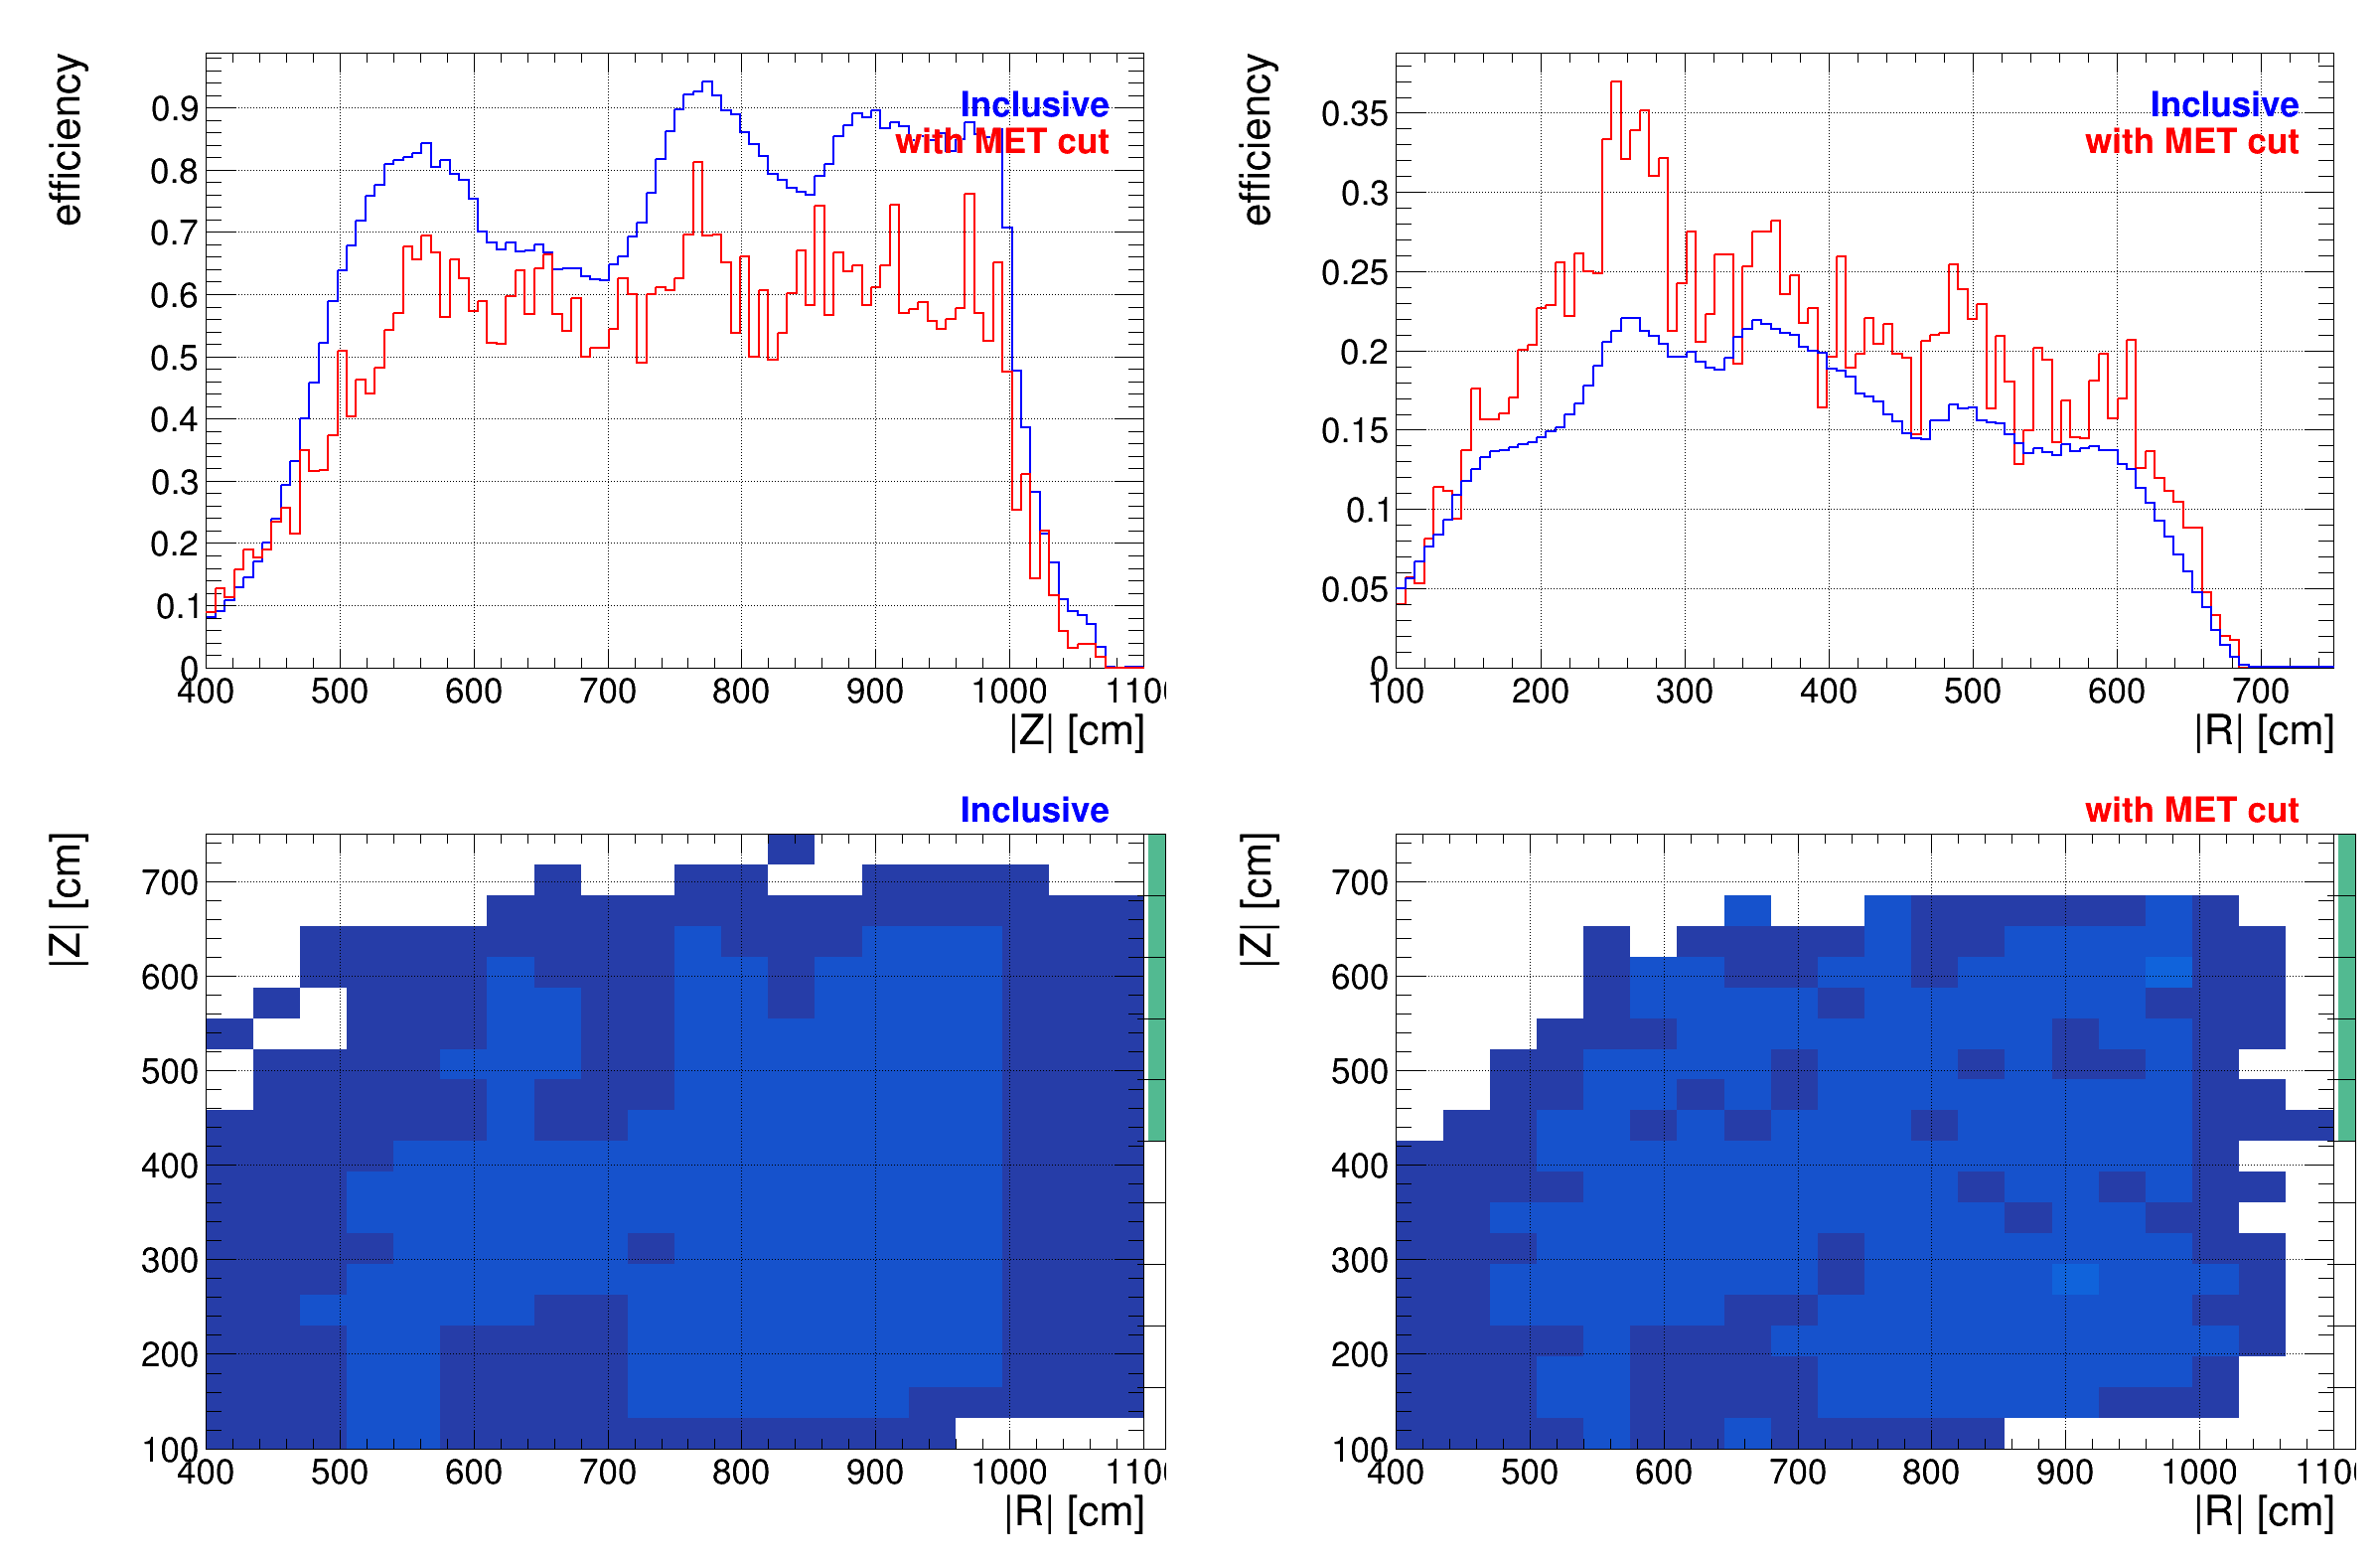

In [12]:
# Cluster Efficiency vs Z Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_z / gLLP_decay_vertex_z
# Cluster Efficiency vs r Decay Position, efficiency = cscRechitCluster_match_gLLP_decay_r / gLLP_decay_vertex_r
# R Decay Position vs Z Decay Position, (Z=[400, 1100], R=[100, 750])
# Signal Efficiency

c = rt.TCanvas("c", "c", 2 * 1200, 2 * 800)
c.Divide(2, 2)
c.Draw()


vcsc_pre, vgen_pre = "abs_cscRechitCluster_match_gLLP_decay_", "abs_gLLP_decay_vertex_"

zbins, rbins = (400, 1100), (100, 750)
# zbins, rbins = (-1100, -400), (100,  750)
for i, (vv, bins) in enumerate(zip(["z", "r"], [zbins, rbins])):
    c.cd(i + 1)
    vcsc, vgen = vcsc_pre + vv, vgen_pre + vv

    # model_csc_raw, model_csc_met = rdf_raw_matched._create_binning(vcsc), rdf_met_matched._create_binning(vcsc)
    # # model_csc_raw, model_csc_met = rdf_raw._create_binning(vcsc), rdf_met._create_binning(vcsc)
    # model_gen_raw, model_gen_met = rdf_raw._create_binning(vgen), rdf_met._create_binning(vgen)
    # xmin, xmax = min(model_csc_raw[3], model_csc_met[3], model_gen_raw[3], model_gen_met[3]), max(model_csc_raw[4], model_csc_met[4], model_gen_raw[4], model_gen_met[4])

    xmin, xmax = bins
    model = (
        "efficiency_decay_" + vv,
        f" CSC |{vv.upper()}| Decay Vertex Efficiency;|{vv.upper()}| [cm];efficiency",
        nb,
        xmin,
        xmax,
    )

    hh_raw = rdf_raw_matched.Histo1D(vcsc, model)
    # hh_raw = rdf_raw.Histo1D(vcsc, model)
    hh_raw.Divide(rdf_raw.Histo1D(vgen, model).GetPtr())

    hh_met = rdf_met_matched.Histo1D(vcsc, model)
    # hh_met = rdf_met.Histo1D(vcsc, model)
    hh_met.Divide(rdf_met.Histo1D(vgen, model).GetPtr())

    rmax, mmax = hh_raw.GetMaximum(), hh_met.GetMaximum()

    hh_raw.SetLineColor(rdf_raw.default_color)
    hh_met.SetLineColor(rdf_met.default_color)
    if rmax > mmax:
        hh_raw.Draw("same")
        hh_met.Draw("same")
    else:
        hh_met.Draw("same")
        hh_raw.Draw("same")
    gc.extend([hh_raw, hh_met])

    print(hh_raw.Integral(), hh_met.Integral())

    lat.SetTextAlign(33)
    lat.SetTextColor(rdf_raw.default_color)
    lat.DrawLatexNDC(0.95, 0.90, rdf_raw.default_label)
    lat.SetTextColor(rdf_met.default_color)
    lat.DrawLatexNDC(0.95, 0.85, rdf_met.default_label)

lat.SetTextAlign(33)
model_zr = ("", "CSC |R| vs |Z| Decay Efficiency;|R| [cm];|Z| [cm]", 20, *zbins, 20, *rbins)

c.cd(3)  # .SetLogz()
hh_eff_z_r_raw = rdf_raw_matched.Histo2D(vcsc_pre + "z", vcsc_pre + "r", model_zr)
# hh_eff_z_r_raw = rdf_raw.Histo2D(vcsc_pre + 'z', vcsc_pre + 'r', model_zr)
hh_eff_z_r_raw.Divide(rdf_raw.Histo2D(vgen_pre + "z", vgen_pre + "r", model_zr).GetPtr())
hh_eff_z_r_raw.SetMaximum(0.2)
hh_eff_z_r_raw.SetMaximum(0)

hh_eff_z_r_raw.Draw("colz")
lat.SetTextColor(rdf_raw.default_color)
lat.DrawLatexNDC(0.95, 1.00, rdf_raw.default_label)

c.cd(4)  # .SetLogz()
hh_eff_z_r_met = rdf_met_matched.Histo2D(vcsc_pre + "z", vcsc_pre + "r", model_zr)
# hh_eff_z_r_met = rdf_met.Histo2D(vcsc_pre + 'z', vcsc_pre + 'r', model_zr)
hh_eff_z_r_met.Divide(rdf_met.Histo2D(vgen_pre + "z", vgen_pre + "r", model_zr).GetPtr())
hh_eff_z_r_met.SetMaximum(0.2)
hh_eff_z_r_met.SetMaximum(0)
hh_eff_z_r_met.Draw("colz")
lat.SetTextColor(rdf_met.default_color)
lat.DrawLatexNDC(0.95, 1.00, rdf_met.default_label)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


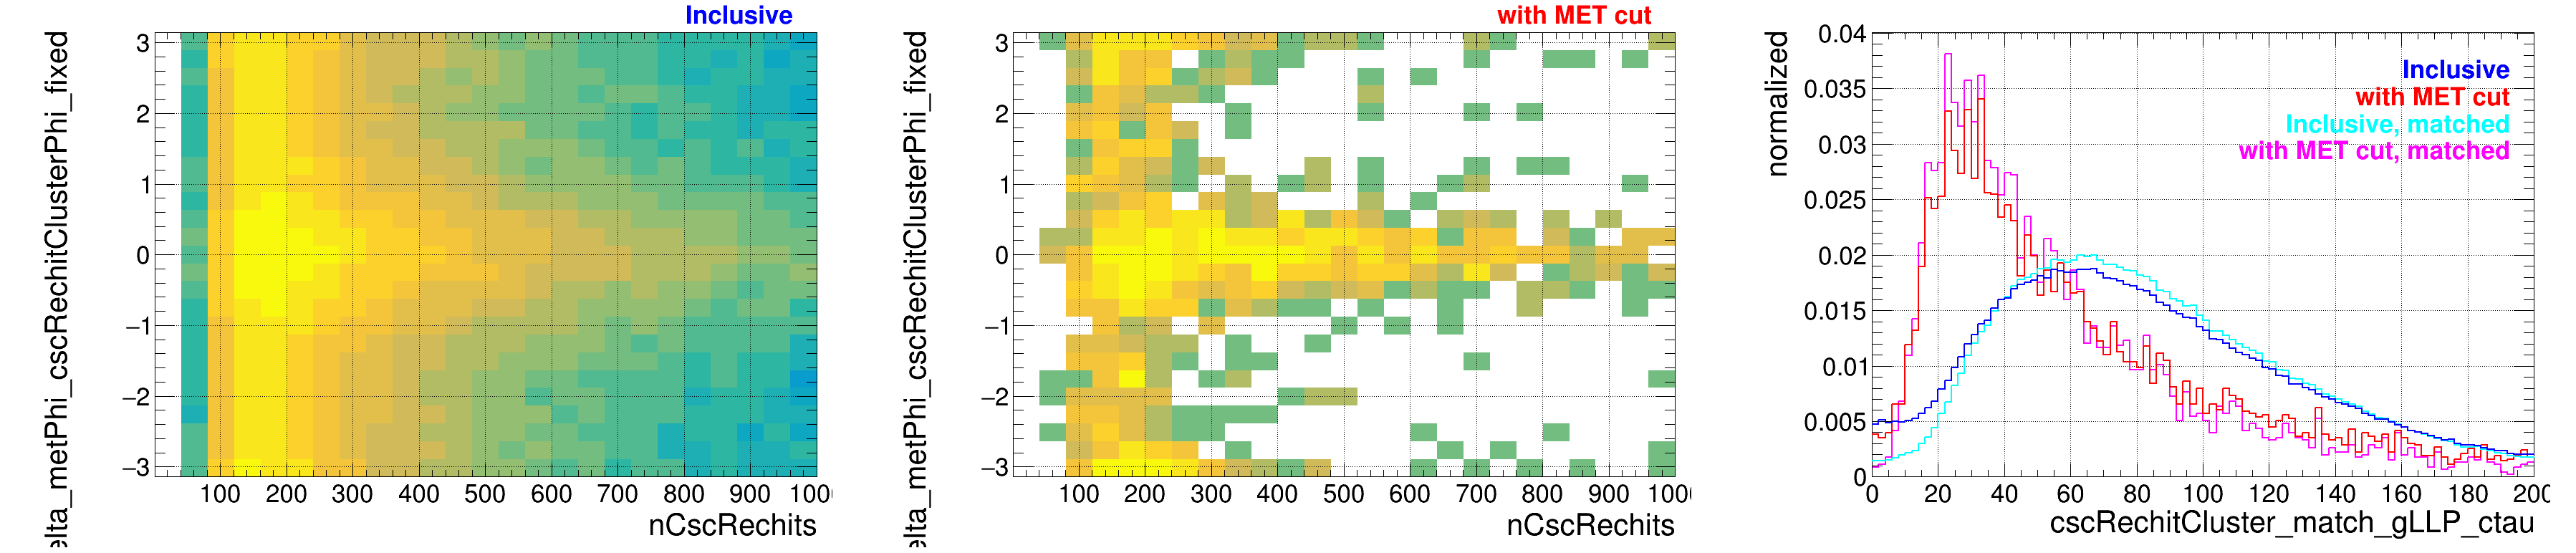

In [13]:
# DeltaPhi vs N_{rechits}
# DeltaPhi, 0 to 3.25
# ctau
c = rt.TCanvas("c", "c", 3 * 1200, 800)
c.Divide(3, 1)
c.Draw()

for i, rdf in enumerate([rdf_raw, rdf_met]):
    c.cd(i + 1).SetLogz()
    hh = rdf.Histo2D(
        "nCscRechits",
        "delta_metPhi_cscRechitClusterPhi_fixed",
        ("", ";nCscRechits;delta_metPhi_cscRechitClusterPhi_fixed;", 100, 1, 1000, 100, -np.pi, np.pi),
    )
    hh.Rebin2D(4, 4)
    hh.Draw("col")
    gc.append(hh)

    lat.SetTextColor(hh.GetLineColor())
    lat.DrawLatexNDC(0.95, 1.00, rdf.default_label)

i += 1
c.cd(i + 1)
v = "cscRechitCluster_match_gLLP_ctau"
hhs, model = Draw1D(
    v, [rdf_raw, rdf_met, rdf_raw_matched, rdf_met_matched], (v, f"{v};{v};count", 100, 0, 200), normalized=True
)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


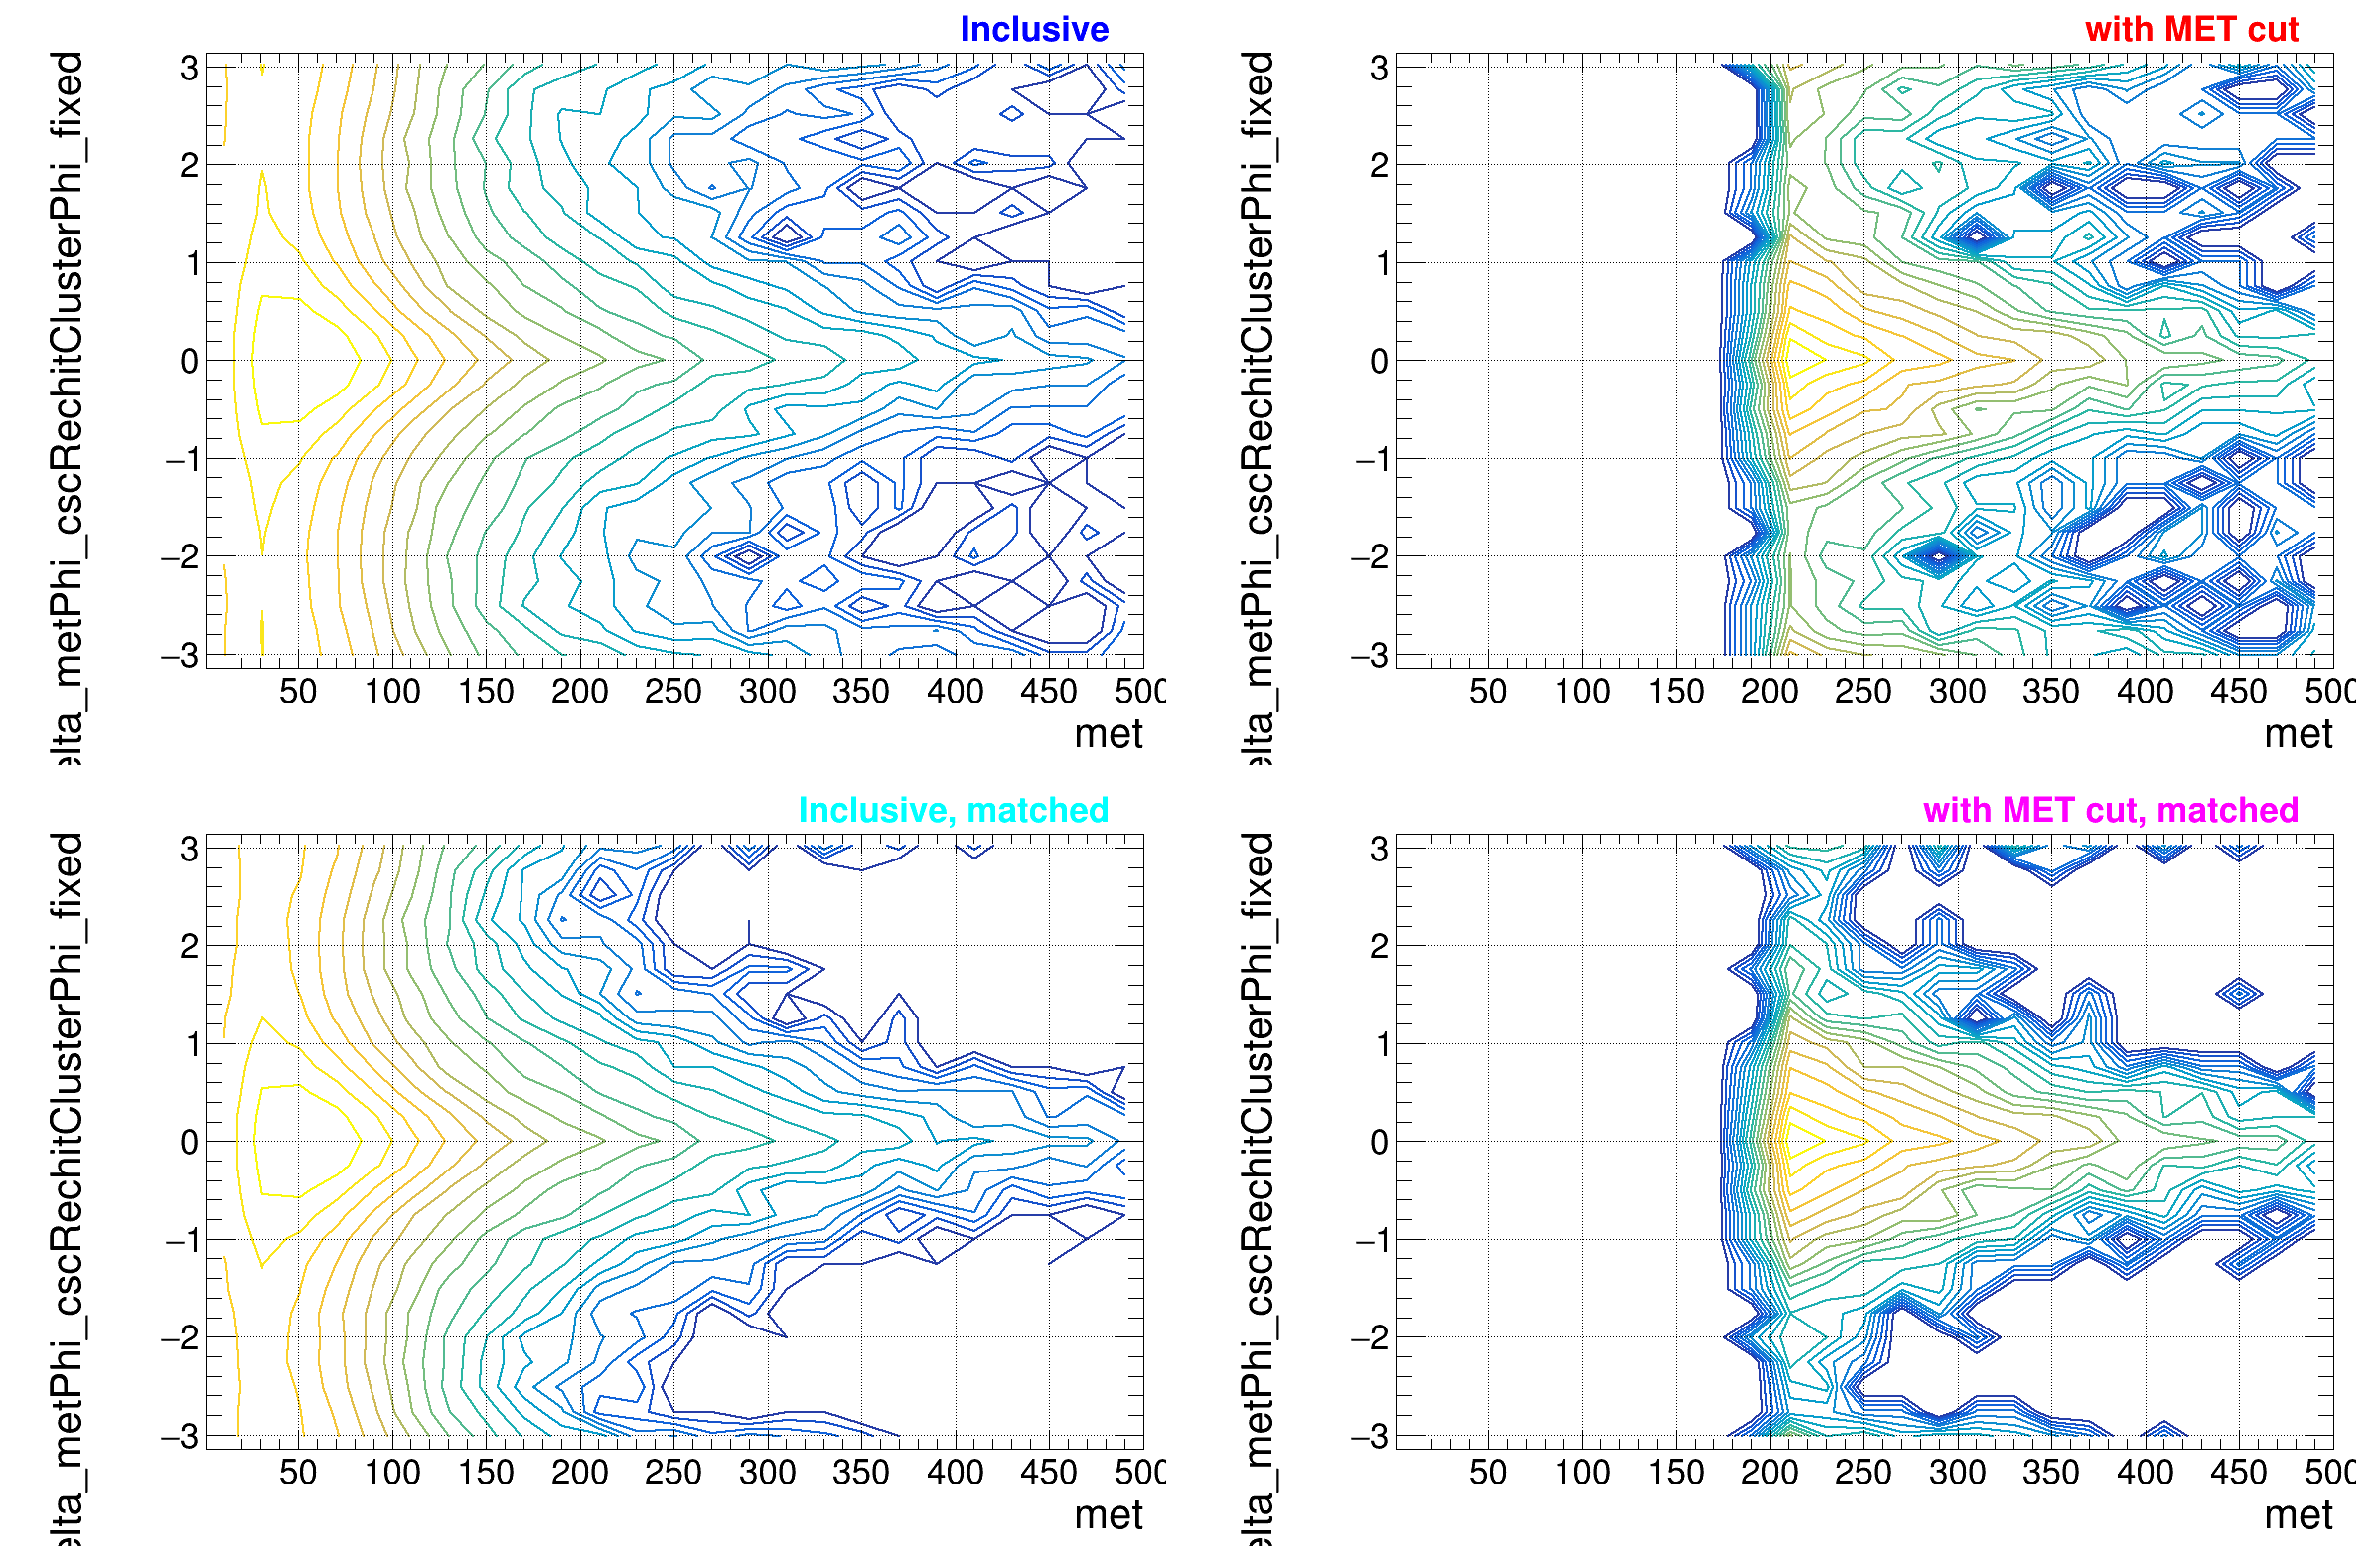

In [14]:
c = rt.TCanvas("c", "c", 2 * 1200, 2 * 800)
c.Divide(2, 2)
c.Draw()

for i, rdf in enumerate([rdf_raw, rdf_met, rdf_raw_matched, rdf_met_matched]):
    c.cd(i + 1).SetLogz()
    hh = rdf.Histo2D(
        "met",
        "delta_metPhi_cscRechitClusterPhi_fixed",
        ("", ";met;delta_metPhi_cscRechitClusterPhi_fixed;", 100, 1, 500, 100, -np.pi, np.pi),
    )
    hh.Rebin2D(4, 4)
    hh.Draw("cont1")
    gc.append(hh)

    lat.SetTextColor(hh.GetLineColor())
    lat.DrawLatexNDC(0.95, 1.00, rdf.default_label)

In [1]:
(arr,) = [
    190,
    191,
    192,
    193,
    194,
    195,
    196,
    197,
    198,
    199,
    200,
    201,
    202,
    203,
    204,
    205,
    206,
    207,
    208,
    209,
    210,
    211,
    212,
    213,
    214,
    215,
    216,
    217,
    218,
    219,
    220,
    221,
    222,
    223,
    224,
    225,
    226,
    227,
    228,
    229,
    230,
    231,
    233,
    234,
    236,
    237,
    238,
    239,
    240,
    241,
    242,
    243,
    244,
    245,
    246,
    247,
    248,
    249,
    250,
    251,
    252,
    253,
    254,
    255,
    256,
    257,
    258,
    259,
    260,
    261,
    262,
    263,
    264,
    265,
    266,
    267,
    268,
    269,
    270,
    271,
    272,
    273,
    274,
    275,
    276,
    277,
    278,
    279,
    280,
    281,
    282,
    283,
    284,
    285,
    286,
    287,
    288,
    289,
    290,
    291,
    292,
    293,
    294,
    295,
    296,
    297,
    298,
    299,
    300,
    301,
    302,
    303,
    304,
    305,
    306,
    307,
    308,
    309,
    310,
    311,
    312,
    313,
    314,
    315,
    316,
    317,
    318,
    319,
    320,
    321,
    322,
    323,
    324,
    325,
    326,
    327,
    328,
    329,
    330,
    331,
    332,
    333,
    334,
    335,
    336,
    337,
    338,
    339,
    340,
    341,
    342,
    343,
    344,
    345,
    346,
    347,
    348,
    349,
    350,
    351,
    352,
    353,
    354,
    355,
    356,
    357,
    358,
    359,
    360,
    361,
    362,
    363,
    364,
    365,
    366,
    367,
    368,
    369,
    370,
    371,
    372,
    373,
    374,
    375,
    376,
    377,
    378,
    379,
    380,
    381,
    382,
    383,
    384,
    385,
    386,
    387,
    388,
]

arr[1:] - arr[:-1]

ValueError: too many values to unpack (expected 1)